In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from sklearn import metrics
import os
from PIL import Image
import xml.etree.ElementTree as ET
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [4]:
# Paths to datasets
data_dir_neu = 'NEU-DET'
data_dir_gc10 = 'gc10'

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# NEU Surface Defects Dataset
class NEUSurfaceDefectsDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Start labels from 0 to ensure alignment with class indices
        defect_classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
        for label, defect_class in enumerate(defect_classes, start=10):
            class_dir = os.path.join(self.root_dir, self.split, 'images', defect_class)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory {class_dir} does not exist. Skipping.")
                continue

            image_files = os.listdir(class_dir)
            self.image_paths.extend([os.path.join(class_dir, img_file) for img_file in image_files])
            self.labels.extend([label] * len(image_files))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

class GCC10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        label_dir = os.path.join(self.root_dir, 'lable')  # Path to annotation files

        for annotation_file in os.listdir(label_dir):
            try:
                tree = ET.parse(os.path.join(label_dir, annotation_file))
                root = tree.getroot()

                file_name = root.find('filename').text
                folder_tag = root.find('folder')

                if folder_tag is None:
                    print(f"Warning: Skipping {annotation_file} - No <folder> tag found.")
                    continue

                folder_text = folder_tag.text

                # Handle "all" case
                if folder_text == "all":
                    folder_numbers = list(range(1, 11))  # All classes 1 to 10
                else:
                    try:
                        folder_numbers = [int(folder_text)]
                    except ValueError:
                        print(f"Error: Invalid folder text in {annotation_file}: {folder_text}. Skipping.")
                        continue

                for folder_number in folder_numbers:
                    folder_path = os.path.join(self.root_dir, str(folder_number))
                    image_path = os.path.join(folder_path, file_name)

                    if os.path.exists(image_path):
                        label = folder_number - 1  # Adjust label index for 0-based indexing
                        self.image_paths.append(image_path)
                        self.labels.append(label)
                    else:
                        print(f"Error: Image {file_name} not found in folder {folder_number}. Skipping.")

            except (ET.ParseError, FileNotFoundError) as e:
                print(f"Error processing {annotation_file}: {e}")
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        return image, label


In [5]:
# Combined Dataset
dataset_neu = NEUSurfaceDefectsDataset(root_dir=data_dir_neu, split='train', transform=transform)
dataset_gc10 = GCC10Dataset(root_dir=data_dir_gc10, transform=transform)
# Print out unique labels from each dataset
print("NEU Dataset Original Labels:", set(dataset_neu.labels))
print("GC10 Dataset Original Labels:", set(dataset_gc10.labels))

class ConsistentLabelDataset(Dataset):
    def __init__(self, original_dataset, label_offset=0):
        self.original_dataset = original_dataset
        self.label_mapping = self._create_label_mapping(label_offset)
        
        # Remap labels
        self.image_paths = original_dataset.image_paths
        self.labels = [self.label_mapping[label] for label in original_dataset.labels]

    def _create_label_mapping(self, label_offset):
        # Get unique original labels and sort them
        unique_labels = sorted(set(self.original_dataset.labels))
        
        # Create a mapping that ensures labels start from the given offset
        label_mapping = {old_label: idx + label_offset for idx, old_label in enumerate(unique_labels)}
        return label_mapping

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Retrieve original image and use mapped label
        image, _ = self.original_dataset[idx]
        label = self.labels[idx]
        return image, label


# Create consistent label datasets
# Apply consistent labeling with offsets
dataset_neu_consistent = ConsistentLabelDataset(dataset_neu, label_offset=10)
dataset_gc10_consistent = ConsistentLabelDataset(dataset_gc10, label_offset=0)

# Combine datasets
combined_dataset = ConcatDataset([dataset_gc10_consistent, dataset_neu_consistent])



# Split Dataset
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# DataLoader with custom collate function
batch_size = 32
def custom_collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    
    if len(batch) == 0:
        return None, None
    
    # Separate images and labels
    images, labels = zip(*batch)
    
    # Convert to tensors
    images = torch.stack(images)
    labels = torch.tensor(labels)
    
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)



# Additional data validation
def validate_data_loader(data_loader):
    for batch_idx, (images, labels) in enumerate(data_loader):
        if images is None or labels is None:
            print(f"Batch {batch_idx} contains None values")
            continue
        
        print(f"Batch {batch_idx}:")
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Labels min:", labels.min(), "Labels max:", labels.max())
        
        # Check for any NaN or infinite values
        if torch.isnan(images).any():
            print("NaN values found in images")
        if torch.isinf(images).any():
            print("Infinite values found in images")

# Run validation


all_labels = dataset_neu.labels + dataset_gc10.labels
print("Min label:", min(all_labels), "Max label:", max(all_labels))
print("NEU labels:", set(dataset_neu.labels))
print("GC10 labels:", set(dataset_gc10.labels))



Error: Image img_01_425000300_00103.jpg not found in folder 1. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 2. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 3. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 5. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 6. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 7. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 8. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 9. Skipping.
Error: Image img_01_425000300_00103.jpg not found in folder 10. Skipping.
Error: Image img_01_425507400_00088.jpg not found in folder 1. Skipping.
Error: Image img_01_425507400_00088.jpg not found in folder 2. Skipping.
Error: Image img_01_425507400_00088.jpg not found in folder 3. Skipping.
Error: Image img_01_425507400_00088.jpg not found in folder 4. Skipping.
Error: Image img_01_425507400_00088.jpg not found 

In [6]:
# Model
num_classes = 16  # Adjusted for 16 total classes
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
for images, labels in train_loader:
    print("Labels in batch:", labels)
    assert labels.min() >= 0 and labels.max() < 16, "Label out of range!"
    break
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch:", labels)
    break
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name(0))
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

d:\Idenfication-of-Surface-Defects-Project-main\Idenfication-of-Surface-Defects-Project-main\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Idenfication-of-Surface-Defects-Project-main\Idenfication-of-Surface-Defects-Project-main\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Labels in batch: tensor([ 2, 11,  5, 13, 12,  6,  0,  2, 11,  5,  5,  5,  6, 10,  0, 10,  3,  5,
        13,  8,  5, 15, 11, 13,  5, 15,  8, 14, 12,  1,  6, 12])
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch: tensor([ 5, 11,  1,  5,  5,  5, 10,  5,  5, 11,  0,  5, 12,  2, 15,  5, 13,  3,
         1,  5,  5, 12, 14,  5, 13, 12,  0,  3,  2, 10,  9,  0])
CUDA Available: True
Current Device: 0
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [7]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    phases = ['train', 'val', 'test']
    training_curves = {}
    for phase in phases:
        training_curves[phase + '_loss'] = []
        training_curves[phase + '_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_batches = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if inputs is None or labels is None:  # Additional safety check
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_batches += 1

            if phase == 'train':
                scheduler.step()  # Update the learning rate

            if total_batches > 0:
                epoch_loss = running_loss / (total_batches * batch_size)
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                training_curves[phase + '_loss'].append(epoch_loss)
                training_curves[phase + '_acc'].append(epoch_acc)

                print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_epoch = epoch
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_curves

print(f"Length of NEU dataset: {len(dataset_neu)}")
print(f"Length of GC10 dataset: {len(dataset_gc10)}")
print(f"Length of combined dataset: {len(combined_dataset)}")



Length of NEU dataset: 1440
Length of GC10 dataset: 2294
Length of combined dataset: 3734


In [8]:
num_epochs = 10 # Or your preferred number of epochs
model, training_curves = train_classification_model(
    model, 
    {'train': train_loader, 'val': val_loader, 'test': test_loader},
    {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)},
    criterion, optimizer, scheduler, num_epochs=num_epochs
)


Epoch 1/10
----------
train Loss: 0.8870 Acc: 0.7235
val   Loss: 1.0333 Acc: 0.7346
test  Loss: 1.0091 Acc: 0.6684

Epoch 2/10
----------
train Loss: 0.5782 Acc: 0.8112
val   Loss: 0.6091 Acc: 0.8284
test  Loss: 0.6753 Acc: 0.7834

Epoch 3/10
----------
train Loss: 0.4813 Acc: 0.8457
val   Loss: 1.4365 Acc: 0.6863
test  Loss: 1.0772 Acc: 0.7112

Epoch 4/10
----------
train Loss: 0.3952 Acc: 0.8681
val   Loss: 0.4614 Acc: 0.8418
test  Loss: 0.4590 Acc: 0.8663

Epoch 5/10
----------
train Loss: 0.2352 Acc: 0.9160
val   Loss: 1.3943 Acc: 0.7855
test  Loss: 1.1785 Acc: 0.8262

Epoch 6/10
----------
train Loss: 0.2125 Acc: 0.9287
val   Loss: 0.5988 Acc: 0.8499
test  Loss: 0.4661 Acc: 0.8476

Epoch 7/10
----------
train Loss: 0.1839 Acc: 0.9351
val   Loss: 0.2877 Acc: 0.9088
test  Loss: 0.4379 Acc: 0.8743

Epoch 8/10
----------
train Loss: 0.1201 Acc: 0.9568
val   Loss: 0.3507 Acc: 0.9196
test  Loss: 0.4148 Acc: 0.8930

Epoch 9/10
----------
train Loss: 0.1041 Acc: 0.9635
val   Loss: 0.2947

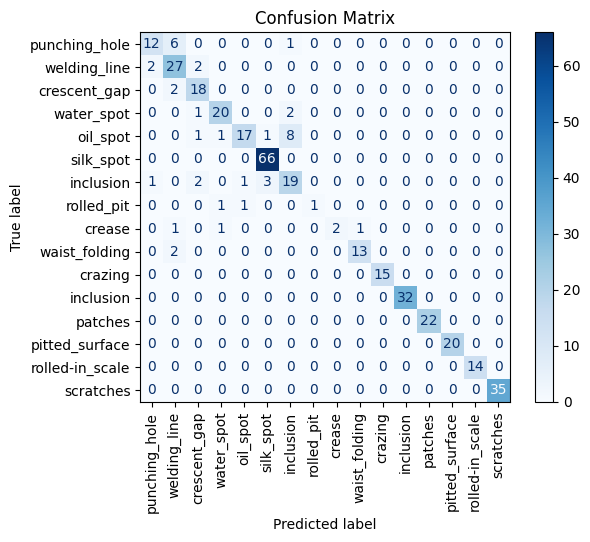

Confusion matrix plotted successfully.


In [9]:
# Combined class labels for NEU (10-15) and GC10 (0-9)
neu_class_labels = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
gc10_class_labels = [
    "punching_hole", "welding_line", "crescent_gap", "water_spot", 
    "oil_spot", "silk_spot", "inclusion", "rolled_pit", "crease", "waist_folding"
]
class_labels = gc10_class_labels + neu_class_labels  # GC10 classes first, NEU classes after

# Confusion matrix plotting function
def plot_cm(model, device, dataloader, class_labels):
    model.eval()
    all_labels = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)

    with torch.no_grad():  # Ensure no gradient computation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels = torch.cat((all_labels, labels), 0)
            all_preds = torch.cat((all_preds, preds), 0)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu(), labels=range(len(class_labels)))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # Rotate labels for better readability
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_cm(model, device, test_loader, class_labels)
print("Confusion matrix plotted successfully.")
